# Comparative analysis of divergent association scores in humans and GPT-3.5turbo and GPT-4
Table of content**

## dependencies

In [1]:
import sys
sys.path.append('..') 
from scripts import dat
import pandas as pd
import numpy as np
from scipy import stats 
from scripts.multiple_test import analyze_results, create_heatmap, most_common_words, create_bar_plot
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pandas as pd
import os
import re
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
colors = {'GPT-3_low_DAT': '#FDB813',
          'GPT-3_mid_DAT':'#EF6C00',
          'GPT-3_high_DAT': '#D32F2F',
          'GPT-3_low_control': '#EEE8AA',
          'GPT-3_mid_control': '#FFE082',
          'GPT-3_high_control':'#FFAB91',
          'GPT-4_low_DAT':'#00B7C3',
          'GPT-4_mid_DAT':'#3F51B5',
          'GPT-4_high_DAT':'#9C27B0',
          'GPT-4_low_control':'#80DEEA',
          'GPT-4_mid_control':'#8C9EFF',
          'GPT-4_high_control':'#CE93D8',
          'Human (8k)':'black',
          'Human (100k)':'darkgrey',
          'GPT-3_mid_ety': '#26A69A',
          'GPT-3_mid_thes': '#D81B60',
          'GPT-3_mid_opp': '#FFEE58',
          'GPT-3_mid_rnd':'#7E57C2',
          'GPT-4_mid_ety': '#1A7466',
          'GPT-4_mid_thes': '#A51645',
          'GPT-4_mid_opp': '#BBA600',
          'GPT-4_mid_rnd':'#4A3280',
          'Bard_mid_DAT':'peru',
          'Bard_mid_control':'#DEC3A3',
          'Claude_low_DAT':'#FDB813',
          'Claude_mid_DAT':'teal',
          'Claude_high_DAT':'#D32F2F',
          'Claude_mid_control':'#1ACCCC',
          'Pythia_mid_DAT':'#603080',
          'Pythia_mid_control':'#BF9FDF',
          'StableLM_mid_DAT':'darkgreen',
          'StableLM_mid_control':'#80FF80',
          'StableLMoass_mid_DAT':'deeppink',
          'StableLMoass_mid_control':'pink',
          'RedPajama_mid_DAT':'#FF0000',
          'RedPajama_mid_control':'#FF8080',
          'Vicuna_mid_DAT':'#7BC8F6',
          'Vicuna_mid_control':'#ADD8E6',
          'Vicuna_mid_ety':'#7BC8F6',}

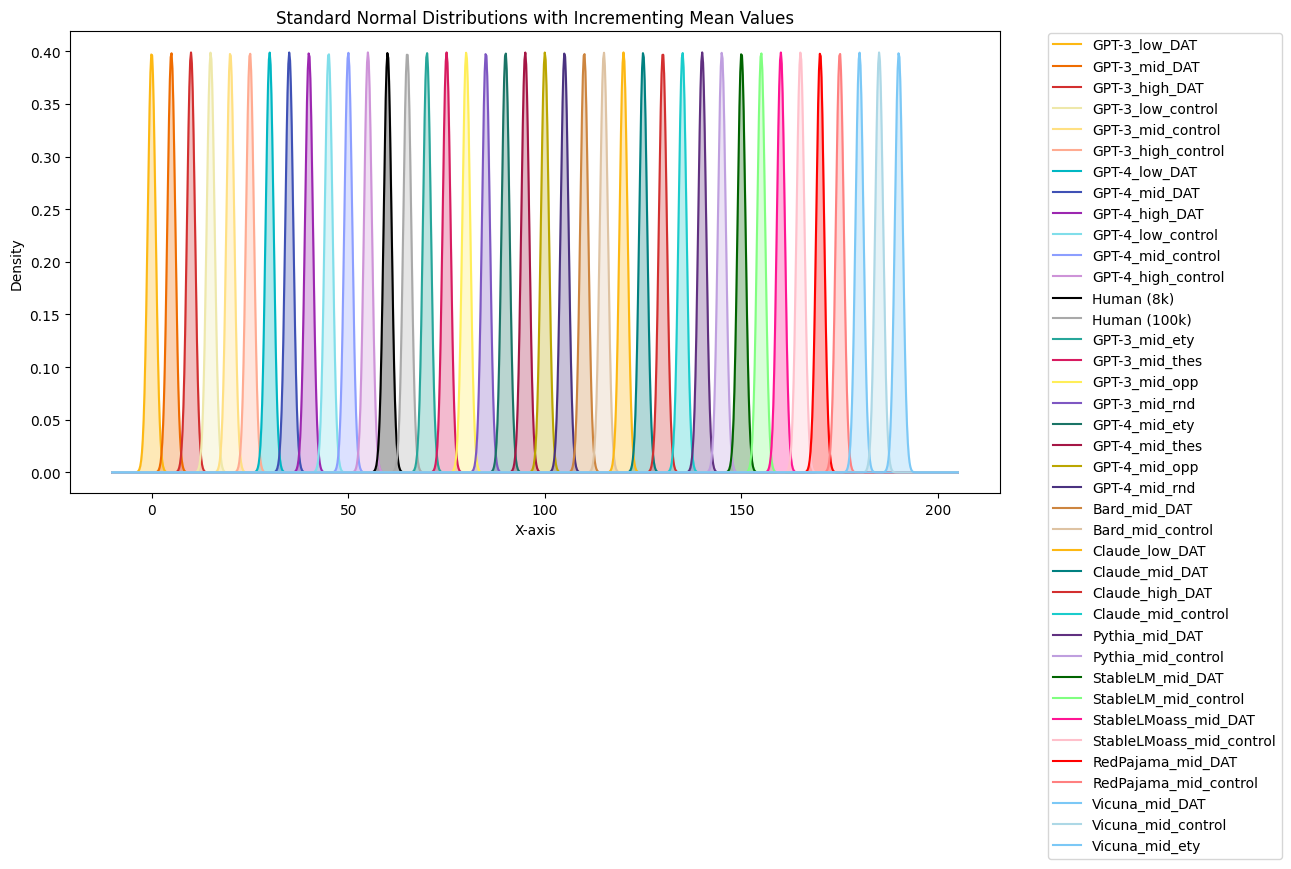

In [3]:
def plot_distributions(colors_, spacing=5):
    x = np.linspace(-10, 10 + len(colors_) * spacing, 1000)
    
    plt.figure(figsize=(12, 6))
    
    for i, (key, color) in enumerate(colors_.items()):
        mean = i * spacing
        y = stats.norm.pdf(x, loc=mean, scale=1)
        plt.plot(x, y, color=color, label=key)
        plt.fill_between(x, y, color=color, alpha=0.3)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.1)
    plt.xlabel('X-axis')
    plt.ylabel('Density')
    plt.title('Standard Normal Distributions with Incrementing Mean Values')
    plt.show()



plot_distributions(colors)


## 1. Load data and model
### Divergent association task model
description of the model and Glove

In [4]:
# GloVe model from https://nlp.stanford.edu/projects/glove/
model_dat = dat.Model("../model/glove.840B.300d.txt", "words.txt")

## Load human data
* Olson and coll. (2021) data - ~8k
* DAT website data harvest - 750k

In [5]:
#load DAT Olson's data
filename = "../human_data_dat/study2.tsv"

# read the data into a DataFrame
df_human = pd.read_csv(filename, sep='\t')

# extract the "dat" column as a list of floats
dat_study = df_human['dat'].astype(float).tolist()

In [6]:
#load DAT big data file
global_crea = pd.read_csv('../human_data_dat/global-creativity.csv')
DAT_bigdata = global_crea['score']

In [7]:
#load 100k human data
final_human_data = pd.read_csv('../human_data_dat/ai-creativity.csv')
DAT_100k = final_human_data['score']

## Fetch machine data
* GPT-3.5turbo
* GPT-4

1. Glob all data files (`.json`).
2. Iterate through samples.
3. Split the tokens and keep only the words.
4. Define strategy used from filename.
5. Define temperature level from filename.
6. Define model from filename
7. Compute DAT score for the given sample of 10 words. (DAT model computes pairwise semantic distances)
8. Store result as a row in a dataframe

In [8]:
def extract_words_with_stars(input_list):
    pattern = r'\*\*(\w+)\*\*'
    words_with_stars = []

    for string in input_list:
        matches = re.findall(pattern, string)
        if matches:
            words_with_stars.extend(matches)

    return words_with_stars

In [9]:
# Define the file path where the data is located
data_path = '../machine_data_dat/'

# Define a dictionary to store the results of model.dat(words)
results_dict = {'Temperature': [], 'Strategy': [], 'Score': [], 'Model': [], 'Control': [], 'Words': []}

# keep track of these so that we can apply further methods of words extractions
bard_data = []
pythia_data = []

# define counters
counter_bard = 0
counter_pythia = 0
counter_gpt3 = 0
counter_gpt4 = 0
counter_claude = 0
counter_stablelm = 0
counter_stablelmoasst = 0
counter_red = 0
counter_vicuna = 0

# Loop through each file in the data path
for file in sorted(glob.glob('../machine_data_dat/*.json')):
    # Open the file and load the JSON data
    with open(file, 'r') as f:
        data = json.load(f)
    file = os.path.basename(file)
    # Loop through each key in the JSON data
    for i in data.keys():
        # Split the words into a list
        words = data[i].split()
        if 'bard' in file:
            words = extract_words_with_stars(words)
            bard_data.append(words)
        else:
            # Find the indices of '1.' to '10.'
            indices = [m.start() for m in re.finditer(r'\b(?:[1-9]|10)\.', data[i])]  

            # Extract the words after '1.' to '10.' and store them in a new list
            new_words = []
            for idx in range(len(indices)):
                if idx < len(indices) - 1:
                    new_words.append(data[i][indices[idx] + 3:indices[idx + 1]].strip())
                else:
                    new_words.append(data[i][indices[idx] + 3:].strip())

            words = new_words
        
        # Define the strategy based on the file name
        if 'sample_thes' in file or 'gpt4_thes' in file:
            strategy = 'Thesaurus'
        elif 'sample_oppo' in file or 'gpt4_oppo' in file:
            strategy = 'Opposition'
        elif 'ety' in file:
            strategy = 'Etymology'
        elif 'sample_rand' in file:
            strategy = 'Random'
        elif 'none' in file:
            strategy = 'Original instructions'
        elif 'nothing' in file:
            strategy = 'Control'
        else:
            strategy = 'Original instructions'
        # Define the temperature based on the file name
        if 'temp1.5' in file:
            condition = 'High'
        elif 'temp0.5' in file:
            condition = 'Low'
        elif 'temp1.0' in file:
            condition = 'Mid'
        elif 'temp0.7' in file or "temp0.8" in file:
            condition = 'Mid'
        elif 'temp0.2' in file:
            condition = 'Low'
        elif 'temp0.9' in file:
            condition = 'High'
        elif 'temp1.0' and 'pythia' in file:
            condition = 'High'
        elif 'temp1.2' and 'claude' in file:
            condition = 'High'
        else:
            condition = 'Mid'
        
        # Define the model based on the file name
        if 'gpt4' in file:
            llm = 'GPT-4'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_gpt4 += 1
        elif 'claude' in file:
            llm = 'Claude'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_claude += 1
        elif 'bard' in file:
            llm = 'Bard'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_bard += 1
        elif 'pythia' in file:
            llm = 'Pythia'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_pythia += 1
        elif 'oasst_stablelm' in file:
            llm = 'StableLM-oasst'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_stablelmoasst += 1
        elif 'stablelm' in file:
            llm = 'StableLM'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_stablelm += 1
        elif 'red' in file:
            llm='RedPajama'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_red += 1
        elif 'vicuna' in file:
            llm = 'Vicuna'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_vicuna += 1
        else:
            llm = 'GPT-3'
            if condition == 'Mid' and strategy == 'Original instructions':
                counter_gpt3 += 1
        
        # Loop through each word in the list
        score = model_dat.dat(words)
            
        # Append the results to the dictionary
        results_dict['Temperature'].append(condition)
        results_dict['Strategy'].append(strategy)
        results_dict['Score'].append(score)
        results_dict['Words'].append(words)
        results_dict['Model'].append(llm)
        # Add a columns with binary Control vs. experimental
        if strategy == 'Control':
            results_dict['Control'].append('Control')
        elif strategy == 'Original instructions':
            results_dict['Control'].append('Original instructions')
        else:
            results_dict['Control'].append('Strategy')

# Convert the results dictionary to a Pandas DataFrame
results_df = pd.DataFrame(results_dict)

Number of valid words 10
Number of valid words 9
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 9
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 9
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Num

## Concatenate all human and machine data 

In [10]:
# Concatenate the website data with the results DataFrame
results_df = pd.concat([results_df, pd.DataFrame({'Temperature': np.tile(None, len(DAT_bigdata)),
                                                  'Strategy': np.tile('Original instructions', len(DAT_bigdata)),
                                                  'Score': np.array(DAT_bigdata),
                                                  'Model': np.tile('Human (750k)', len(DAT_bigdata)),
                                                  'Control': np.tile('Original instructions', len(DAT_bigdata))})])
# concat with study data
results_df = pd.concat([results_df, pd.DataFrame({'Temperature': np.tile(None, len(dat_study)),
                                                  'Strategy': np.tile('Original instructions', len(dat_study)),
                                                  'Score': np.array(dat_study),
                                                  'Model': np.tile('Human (8k)', len(dat_study)),
                                                  'Control': np.tile('Original instructions', len(dat_study))})])

# concat with final sample
results_df = pd.concat([results_df, pd.DataFrame({'Temperature': np.tile(None, len(DAT_100k)),
                                                  'Strategy': np.tile('Original instructions', len(DAT_100k)),
                                                  'Score': np.array(DAT_100k),
                                                  'Model': np.tile('Human (100k)', len(DAT_100k)),
                                                  'Control': np.tile('Original instructions', len(DAT_100k))})])

## Save all machine and human data

In [11]:
results_df.to_csv('concatenated_results.csv', index=False)

# 2. Quality control manipulations
## Most common words in humans

In [12]:
import pandas as pd
import collections

n_words = 5  # Set the number of most common words to find

# Concatenate all the words from columns 'word.1' to 'word.10'
all_words = df_human.loc[:, 'word.1':'word.10'].values.flatten()

# Count the occurrences of each word
word_counter = collections.Counter(all_words)

# Find the n most common words
most_common_words_humans = word_counter.most_common(n_words)

# Calculate the percentage of occurrences for each of the n most common words
total_words = len(all_words)
most_common_words_percentage = [(word, count / total_words * 1000) for word, count in most_common_words_humans]

# Print the n most common words with their percentages
print(f"Top {n_words} most common words with their percentage of occurrence:")
for word, percentage in most_common_words_percentage:
    print(f"{word}: {percentage:.2f}%")



'''car      1000000 13820   1.38
dog      1000000 12394   1.24
tree     1000000 10199   1.02
cat      1000000  7904   0.790
book     1000000  7035   0.704
house    1000000  6171   0.617
water    1000000  5651   0.565
mountain 1000000  5649   0.565
computer 1000000  5216   0.522
cloud    1000000  4959   0.496'''



Top 5 most common words with their percentage of occurrence:
Car: 11.68%
Tree: 9.40%
Dog: 8.38%
car: 8.03%
Book: 6.44%


'car      1000000 13820   1.38\ndog      1000000 12394   1.24\ntree     1000000 10199   1.02\ncat      1000000  7904   0.790\nbook     1000000  7035   0.704\nhouse    1000000  6171   0.617\nwater    1000000  5651   0.565\nmountain 1000000  5649   0.565\ncomputer 1000000  5216   0.522\ncloud    1000000  4959   0.496'

## Visualize adherence to instructions in machines
Using the ratio of the number of responses that have been harvested vs. number of responses on which DAT scores were computed as a measure of the level attrition in each model

In [13]:
counting = {"Bard":counter_bard, "Pythia":counter_pythia, "GPT-3":counter_gpt3, "GPT-4": counter_gpt4, "Claude": counter_claude, "StableLM": counter_stablelm, "StableLM-oasst": counter_stablelmoasst, "RedPajama":counter_red, "Vicuna": counter_vicuna}

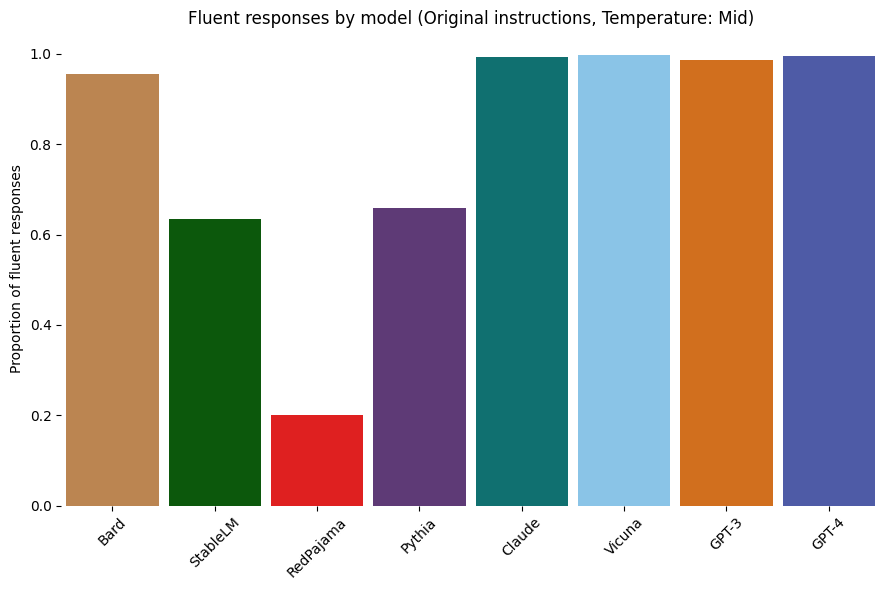

In [14]:
# Extract data
import seaborn as sns

# Extract data
data = {}
mean_scores = {}
for model in results_df["Model"].unique():
    # these were not used
    if "Human" in model or "StableLM-oasst" in model:
        continue
    temp_df = results_df.loc[(results_df["Model"] == model) &
                             (results_df["Strategy"]=="Original instructions") &
                             (results_df["Temperature"]=="Mid")].dropna()
    # ratio for the given model
    data[model] = len(temp_df) / counting[model]
    mean_scores[model] = temp_df["Score"].mean(skipna=True)

# Sort data by mean score
data = dict(sorted(data.items(), key=lambda x: mean_scores[x[0]], reverse=False))

# Plot bar chart
fig, ax = plt.subplots(figsize=(9,6))
sns.barplot(x=list(data.keys()), y=list(data.values()), palette=[colors[model+"_mid_DAT"] for model in data.keys()], ax=ax, width=.9)
sns.despine(left=True, bottom=True)
ax.set_ylabel("Proportion of fluent responses")
ax.set_title("Fluent responses by model (Original instructions, Temperature: Mid)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Word counts

[[('Tree', 10.2), ('Dog', 12.4), ('Car', 13.8)], [], [('volcano', 39.442231075697215), ('elephant', 60.95617529880478), ('microscope', 65.73705179282868)], [('ocean', 26.448736998514118), ('computer', 28.52897473997028), ('elephant', 36.84992570579495)], [('lamp', 49.89979959919839), ('butterfly', 53.3066132264529), ('river', 56.446225784903135)], [('love', 49.75073761318547), ('ocean', 50.361176111506765), ('chair', 57.482958591921864)], [('aardvark', 4.930779442442633), ('abyss', 5.120424805613504), ('able', 5.120424805613504)], [('coffee', 12.471655328798187), ('water', 13.7674117265954), ('tree', 16.19695497246518)], [('happy', 9.524806363826668), ('love', 11.513502198032239), ('bright', 19.991626543855975)], [('hate', 29.773366908606135), ('love', 30.365871722707748), ('hope', 30.662124129758556)]]


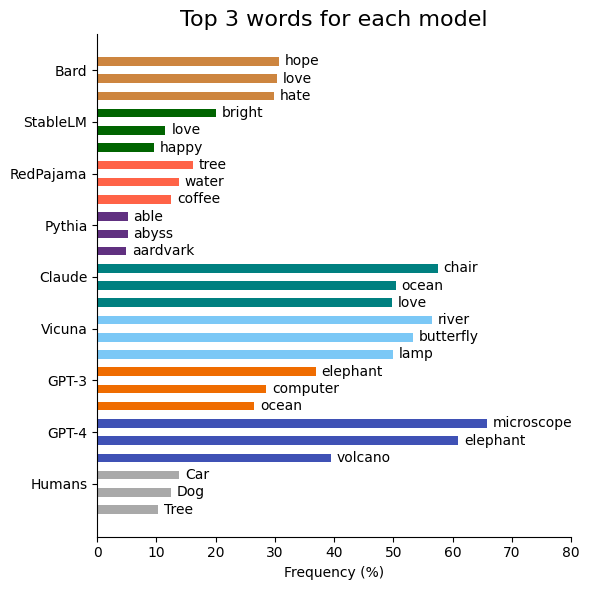

In [15]:
colors_ = {
    'Humans': 'darkgrey',
    'GPT-4': '#3F51B5',
    'GPT-3': '#EF6C00',
    'Vicuna': '#7BC8F6',
    'Claude': 'teal',
    'Pythia': '#603080',
    'RedPajama': 'tomato',
    'StableLM': 'darkgreen',
    'Bard': 'peru',
    
}

# Add the human data
human_data = [("Tree", 10.2), ("Dog", 12.4), ("Car", 13.8)]
model_word_counts = []

# Assuming results_df is already loaded
model_names = list(colors_.keys())

n_words = 3

# Iterate over all models and accumulate the word counts
for model_name in model_names:  # Exclude the last model_name, "Human"
    temp = 'Mid'
    strategy = 'Original instructions'

    df = results_df.loc[(results_df['Model'] == model_name) & (results_df['Strategy'] == strategy) &
                        (results_df['Temperature'] == temp)].dropna()

    all_words = df['Words'].tolist()
    n_lists = len(all_words)
    all_words = [word for sublist in all_words for word in sublist]

    word_counts = most_common_words(all_words, n_words)
    word_counts_percentage = [(word, count / len(all_words) * 10 * 100) for word, count in word_counts]
    model_word_counts.append(sorted(word_counts_percentage, key=lambda x: x[1], reverse=False))

# Add the human data to model_word_counts at the beginning
model_word_counts.insert(0, human_data)
#model_word_counts.append(human_data)
print(model_word_counts)
#remove empty lists
model_word_counts = [x for x in model_word_counts if x != []]
# Create the horizontal bar plot
fig, ax = plt.subplots(figsize=(6, 6))

bar_width = 0.50
bar_positions = [i for i in range(n_words * len(model_names))]

for i, (model_name, word_counts) in enumerate(zip(model_names, model_word_counts)):
    word_labels, counts = zip(*word_counts)
    for j, (word, count) in enumerate(zip(word_labels, counts)):
        ax.barh(bar_positions[i * n_words + j], count, bar_width, color=colors_[model_name])
        ax.text(count + 1, bar_positions[i * n_words + j], word, va='center')
# set model names
ax.set_yticks([(i * n_words) + n_words / 2 for i in range(len(model_names))])
ax.set_yticklabels(model_names)
# axes names
ax.set_xlabel('Frequency (%)')
ax.set_title('Top 3 words for each model', fontsize=16)
ax.set_xlim(0, 80)
# remove box frame
ax.spines['top'].set_visible(False)
# remove right frame
ax.spines['right'].set_visible(False)
plt.tight_layout()

# Save the plot
plt.savefig(f"{'_'.join(model_names)}_top{n_words}_words_percentage.png", dpi=300)

# Show the plot
plt.show()


In [16]:
def create_bar_plot(word_counts, n_lists=None, ylim=(0, 90),
                    palette_name='Set2', save=False, modelname=' ',
                    temp=' ', strategy=' ', alpha=0.8, title='Top 10 words'):
    #title = '{} ({} temperature)'.format(modelname, temp)
    filename = '{}_word-counts_{}_{}.png'.format(modelname, temp, strategy)
    if n_lists is None:
        n_lists = len(word_counts)/10
    words, counts = zip(*word_counts)
    num_words = len(words)
    
    # Create an array of colors
    #colors = plt.get_cmap(palette_name)(np.linspace(0.6, 0.8, num_words))
    
    # Set the bar width to have more space between bars
    bar_width = 0.5
    
    # Create the bar plot
    fig, ax = plt.subplots()
    bars = ax.bar(words, [(x/n_lists)*100 for x in counts], width=bar_width, color=palette_name, alpha=alpha)
    
    # change x label size
    ax.tick_params(axis='x', labelsize=12)
    
    #change y label size
    ax.tick_params(axis='y', labelsize=12)
    # Add angle to the bar labels
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    
    # Set plot labels and title
    ax.set_xlabel('Words', fontsize=14)
    ax.set_ylabel('Percentage (%)', fontsize=14)
    #ax.set_title('Top 10 Most Common Words - {}'.format(title))
    ax.set_title(title, fontsize=18)
    ax.set_ylim(ylim)
    # Adjust the bottom margin to prevent cropping of labels when saving
    plt.subplots_adjust(bottom=0.25)
    
    if save:
        plt.savefig(filename, dpi=300)
    else :
        plt.show()

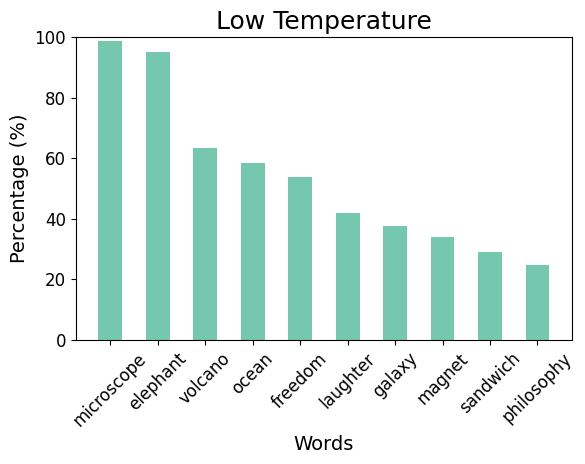

In [20]:
modelname = 'GPT-4'
temp = 'Low'
strategy = 'Original instructions'
palette = sns.color_palette("Set2", 1)
n_words = 10

df = results_df.loc[(results_df['Model']==modelname) & (results_df['Strategy']==strategy ) &
                    ((results_df['Temperature']==temp))].dropna()

# Use explode to create a new row for each word
all_words = [word for word_list in df['Words'] for word in word_list]
all_words = df['Words'].tolist()
n_lists = len(all_words)
all_words = [word for sublist in all_words for word in sublist]

create_bar_plot(most_common_words(all_words, n_words), n_lists=n_lists, ylim=(0, 100), alpha=0.9, palette_name=palette,
                save=True, modelname=modelname, temp=temp, strategy=strategy, title='Low Temperature')

# 3. Main analyses
## Overall differences between human and machines
figure 1

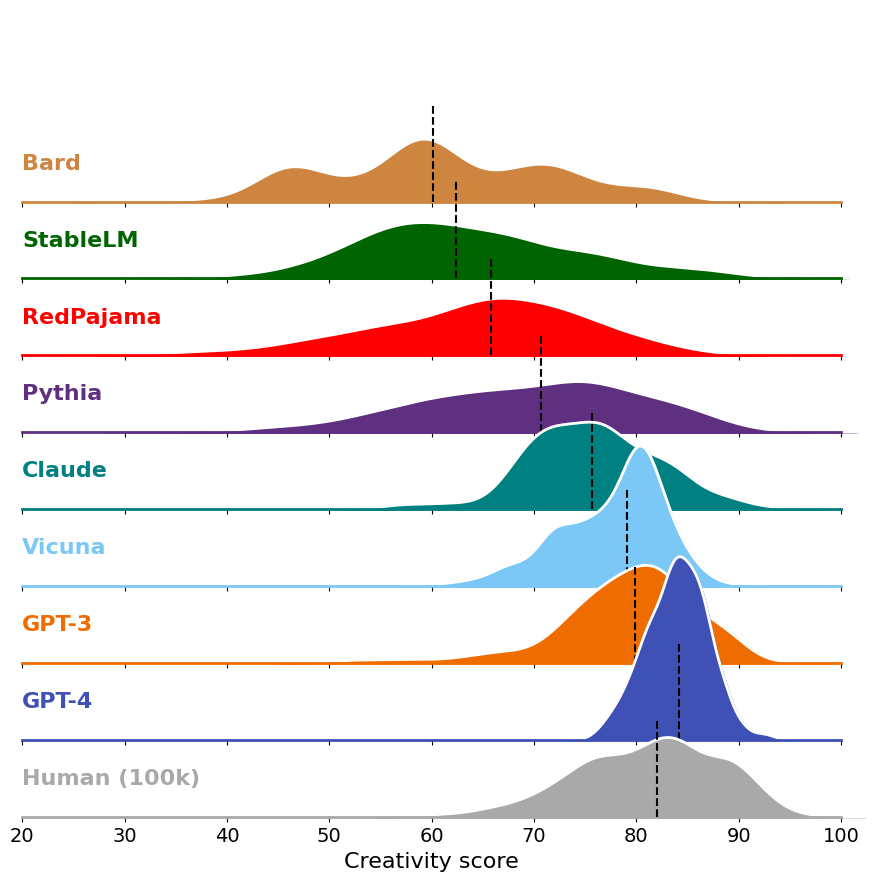

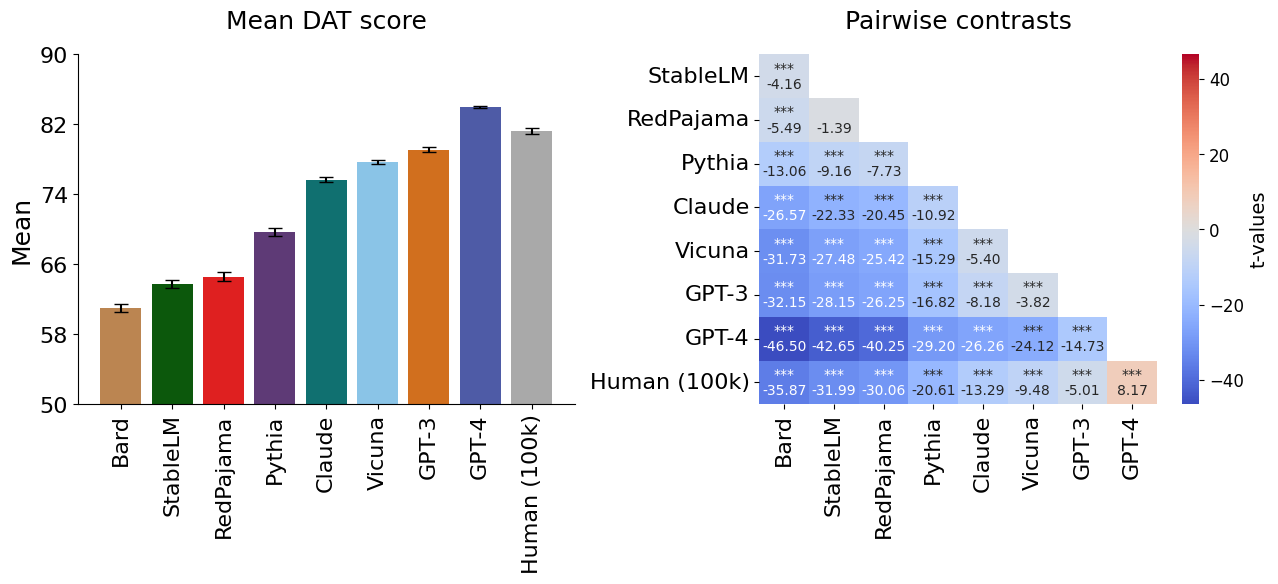

In [21]:
# Initialize the FacetGrid object
pal = [colors['GPT-3_mid_DAT'],
       colors['GPT-4_mid_DAT'],
       colors['Claude_mid_DAT'],
       colors['StableLM_mid_DAT'],
       colors['Human (100k)'],
       colors['Bard_mid_DAT'],
       colors['Pythia_mid_DAT'],
       colors['RedPajama_mid_DAT'],
       colors['Vicuna_mid_DAT']]
order = ['Bard', 'StableLM','RedPajama', 'Pythia', 'Claude', 'Vicuna', 'GPT-3', 'GPT-4', 'Human (100k)']
pal_order = [pal[5], pal[3], pal[7], pal[6], pal[2], pal[8], pal[0], pal[1], pal[4]]
df = results_df.loc[(results_df['Strategy']=='Original instructions') &
                    (results_df['Temperature']=='Mid') | (results_df['Temperature'].isnull())]

df = df.groupby('Model').apply(lambda x: x[np.abs(x['Score'] - x['Score'].mean()) <= 3 * x['Score'].std()]).reset_index(drop=True)
df = df.groupby('Model').apply(lambda x: x.sample(min(len(x), 500), random_state=32)).reset_index(drop=True)

g = sns.FacetGrid(df, row="Model", hue="Model", aspect=9, height=1, row_order=order, palette=pal_order, hue_order=order)

# make transparent background
for ax in g.axes.flat:
    ax.set_facecolor('none')
# Draw the densities in a few steps
g.map(sns.kdeplot, "Score",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    # check if Human is in the label
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,fontsize=16)
g.map(label, "Score")
mean_conf, pvals, tvals = analyze_results(df, 'Model', order)
# Add vertical lines for mean and confidence intervals
for ax, model in zip(g.axes.flat, order):
    if model == 'Human (8k)':
        print(mean_conf[mean_conf['Model'] == model]['median'])
        ax.axvline(mean_conf[mean_conf['Model'] == model]['median'].values[0], color='white', linestyle='--', ymin=0, ymax=0.5)
    else:
        ax.axvline(mean_conf[mean_conf['Model'] == model]['median'].values[0], color='black', linestyle='--', ymin=0, ymax=0.5)

for ax in g.axes.flat:
    ax.set_xlabel('Creativity score', fontsize=16)
    for label in ax.get_xticklabels():
            label.set_fontsize(14)
# Remove axes details that don't play well with overlap
g.set_titles("")
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.60)
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.set(xlim=(20, 100))
g.savefig('DAT_LLMs_humans_ridge_median_test')
create_heatmap(mean_conf, 'Model', tvals_table=tvals, pvals_table=pvals,
               pal=[pal[5], pal[3], pal[7], pal[6], pal[2], pal[8], pal[0], pal[1], pal[4]], order=order, xlim=(50,90), save='DAT_GPT_humans_models_test', large=(13, 6))

## Control vs DAT
figure 2

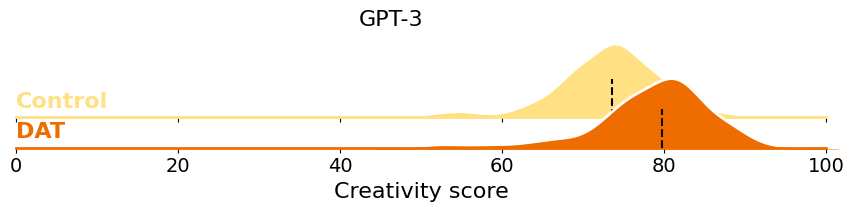

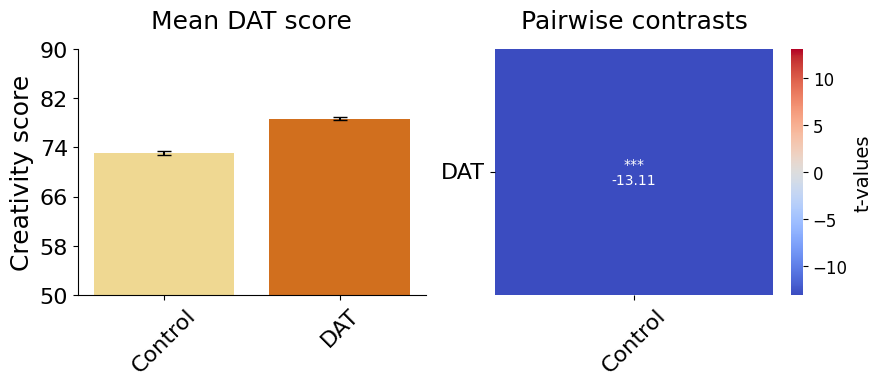

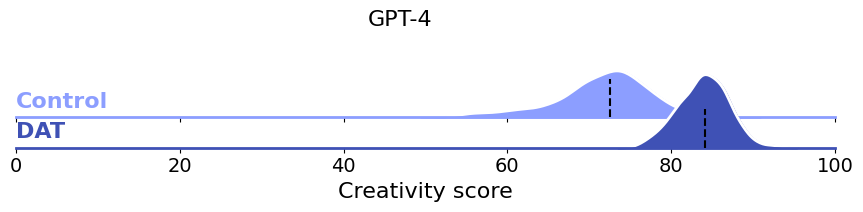

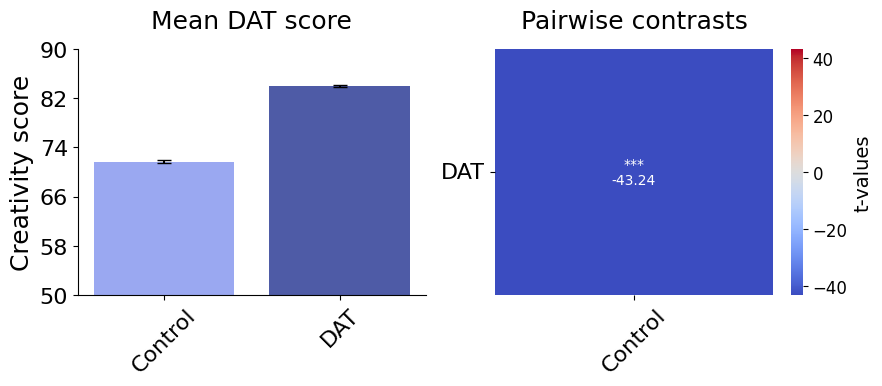

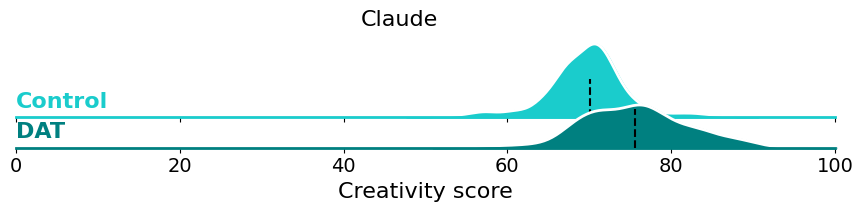

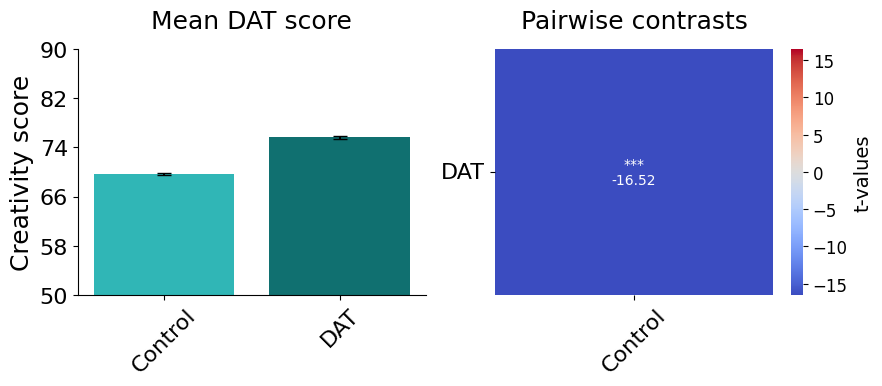

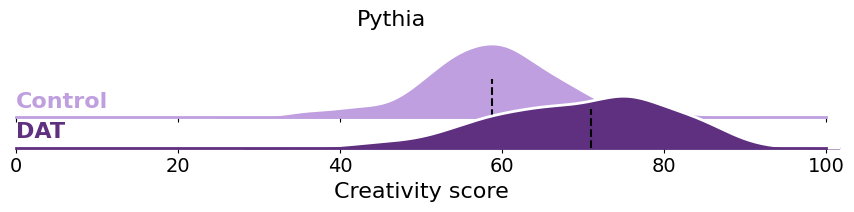

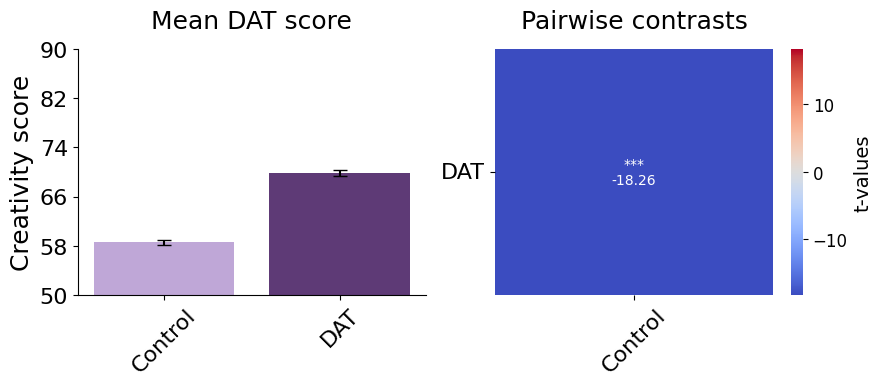

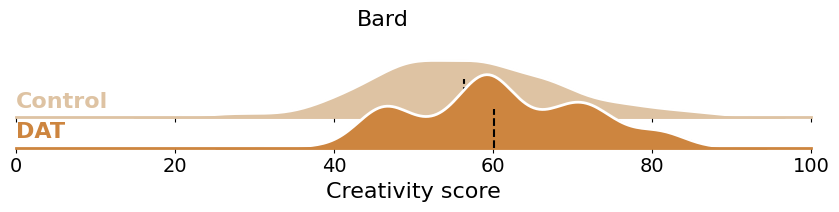

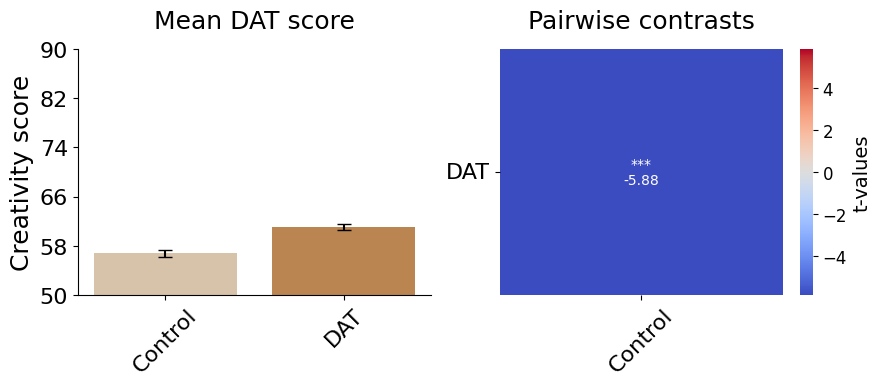

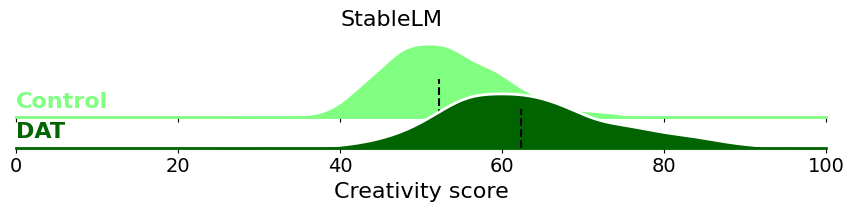

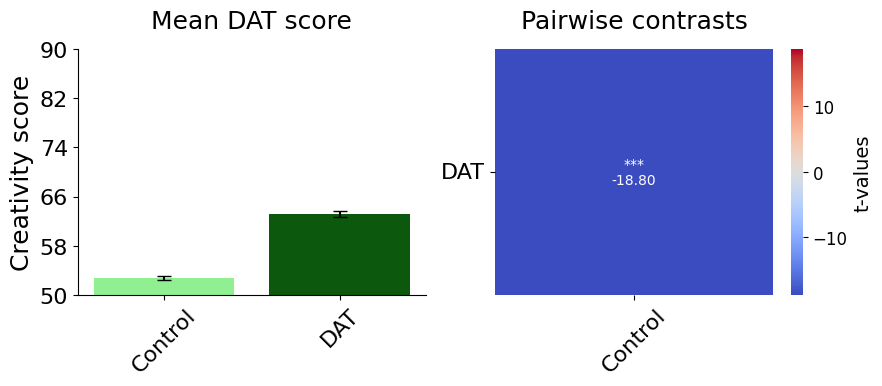

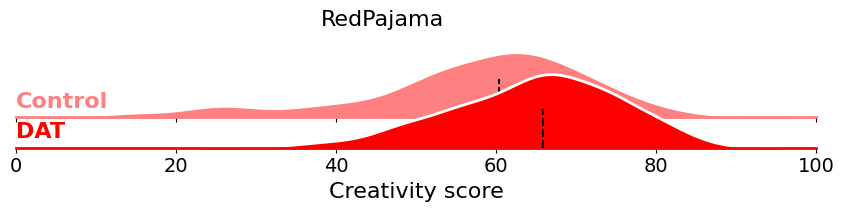

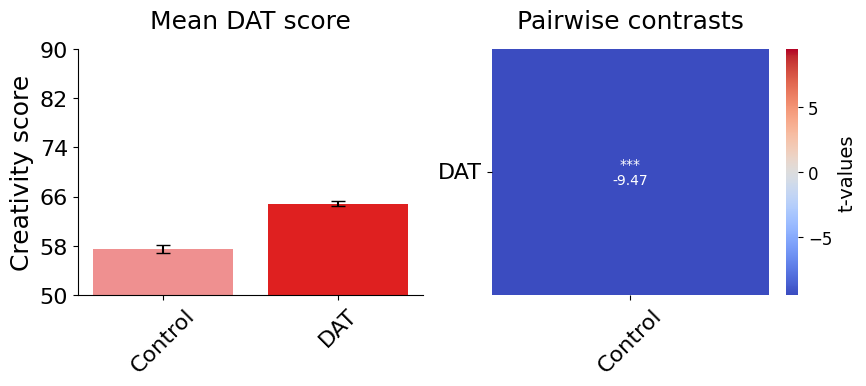

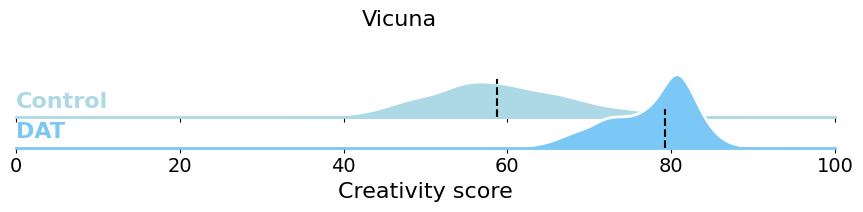

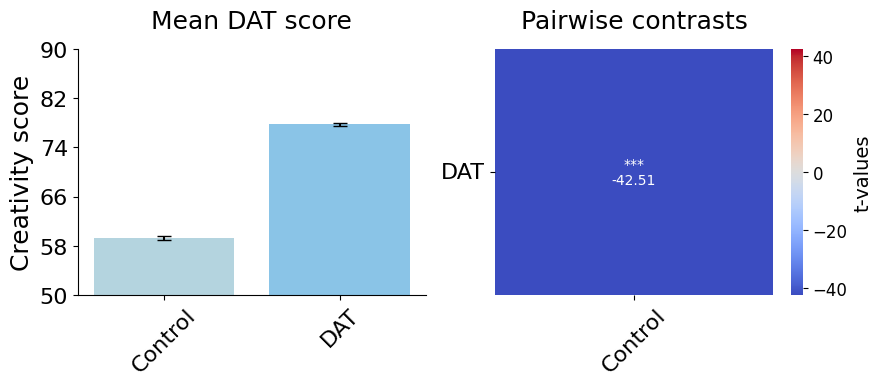

In [22]:
#from multiple_test import *
list_of_dfs = [results_df.loc[(results_df['Model']=='GPT-3') &
                              (results_df['Control']!='Strategy')],
               results_df.loc[(results_df['Model']=='GPT-4') &
                              (results_df['Temperature']=='Mid') &
                              (results_df['Control']!='Strategy')],
               results_df.loc[(results_df['Model']=='Claude') &
                              (results_df['Temperature']=='Mid') &
                              (results_df['Control']!='Strategy')],
               results_df.loc[(results_df['Model']=='Pythia') &
                              (results_df['Temperature']=='Mid') &
                              (results_df['Control']!='Strategy')],
               results_df.loc[(results_df['Model']=='Bard') &
                              (results_df['Temperature']=='Mid') &
                              (results_df['Control']!='Strategy')],
               results_df.loc[(results_df['Model']=='StableLM') &
                              (results_df['Temperature']=='Mid') &
                              (results_df['Control']!='Strategy')],
               results_df.loc[(results_df['Model']=='RedPajama') &
                              (results_df['Temperature']=='Mid') &
                              (results_df['Control']!='Strategy')],
               results_df.loc[(results_df['Model']=='Vicuna') &
                               (results_df['Temperature']=='Mid') &
                              (results_df['Control']!='Strategy')],]

for e, df in enumerate(list_of_dfs):
      gpt = df["Model"].unique()[0]
      # Remove observations with more or less than 3 std, and then randomly sample up to 500 observations
      df['Control'] = df['Control'].replace({'Original instructions': 'DAT'})
      df = df.groupby('Control').apply(lambda x: x[np.abs(x['Score'] - x['Score'].mean()) <= 3 * x['Score'].std()]).reset_index(drop=True)
      df = df.groupby('Control').apply(lambda x: x.sample(min(len(x), 500), random_state=42)).reset_index(drop=True)
            

      # Initialize the FacetGrid object
      pal = [colors[f'{gpt}_mid_DAT'], colors[f'{gpt}_mid_control']]
      order = ['Control', 'DAT']
      
      
      g = sns.FacetGrid(df, row="Control", hue="Control", aspect=9, height=1, palette=[pal[1], pal[0]], row_order=order)
      
      # make transparent background
      for ax in g.axes.flat:
            ax.set_facecolor('none')
      # Draw the densities in a few steps
      g.map(sns.kdeplot, "Score",
            bw_adjust=1, clip_on=False,
            fill=True, alpha=1, linewidth=1.5)
      g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)

      # passing color=None to refline() uses the hue mapping
      g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

      # txt = f"{label} ({len(df.loc[df['Control']==label])})"
      # Define and use a simple function to label the plot in axes coordinates
      def label(x, color, label):
            ax = plt.gca()
            txt = f"{label}"
            ax.text(0, .2, txt, fontweight="bold", color=color,
                        ha="left", va="center", transform=ax.transAxes,fontsize=16)
      # change title from the FaceGrid object
      #g.set_titles("Stable LM")
      g.map(label, "Score")
      # increase title size
      g.set_titles(fontsize=16)
      mean_conf, pvals, tvals = analyze_results(df, 'Control', order=order)
      #print(mean_conf)
      # Add vertical lines for mean and confidence intervals
      for ax, model in zip(g.axes.flat, [0,1]):
            ax.axvline(mean_conf['median'][model], color='black', linestyle='--', ymin=0, ymax=0.5)
      # Set the subplots to overlap
      for ax in g.axes.flat:
            ax.set_xlabel('Creativity score', fontsize=16)
            for label in ax.get_xticklabels():
                  label.set_fontsize(14)
      g.figure.subplots_adjust(hspace=-.60)

      # Remove axes details that don't play well with overlap
      g.set_titles("")
      # set the main title of the figure
      
      g.set(yticks=[], ylabel="")
      g.despine(bottom=True, left=True)
      g.set(xlim=(0, 100))
      g.fig.suptitle(df['Model'].unique()[0], fontsize=16)
      g.fig.suptitle(gpt, fontsize=16)
      g.savefig('DAT_GPT_control4_kde_{}'.format(str(e)), dpi=300)
      create_heatmap(mean_conf, 'Control', tvals_table=tvals, pvals_table=pvals, pal=reversed(pal), order=['Control', 'DAT'], 
                     save='DAT_GPT_control6_{}'.format(str(e)), large=(9, 4), xlim=(50,90), rotation=45, axis_name='Creativity score')

## Injecting strategies

In [23]:
def get_palette(model, order):
    color_map = {
        'GPT-3': {
            'Etymology': colors['GPT-3_mid_ety'],
            'DAT': colors['GPT-3_mid_DAT'],
            'Control': colors['GPT-3_mid_control'],
            'Opposition': colors['GPT-3_mid_opp'],
            'Random': colors['GPT-3_mid_rnd'],
            'Thesaurus': colors['GPT-3_mid_thes']
        },
        'GPT-4': {
            'Etymology': colors['GPT-4_mid_ety'],
            'Control': colors['GPT-4_mid_control'],
            'DAT': colors['GPT-4_mid_DAT'],
            'Opposition': colors['GPT-4_mid_opp'],
            'Thesaurus': colors['GPT-4_mid_thes']
        },
        'Vicuna': {
            'Etymology': colors['Vicuna_mid_ety'],
            'Control': colors['Vicuna_mid_control'],
            'DAT': colors['Vicuna_mid_DAT'],
        }
    }

    return [color_map[model][strategy] for strategy in order]


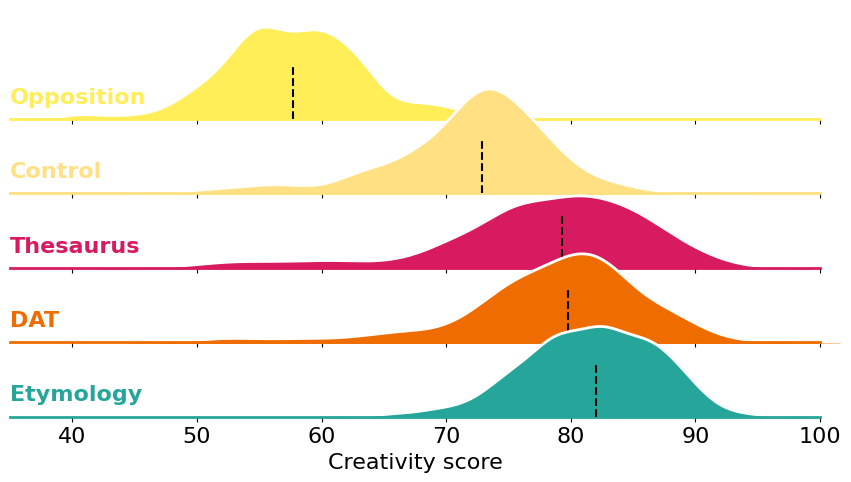

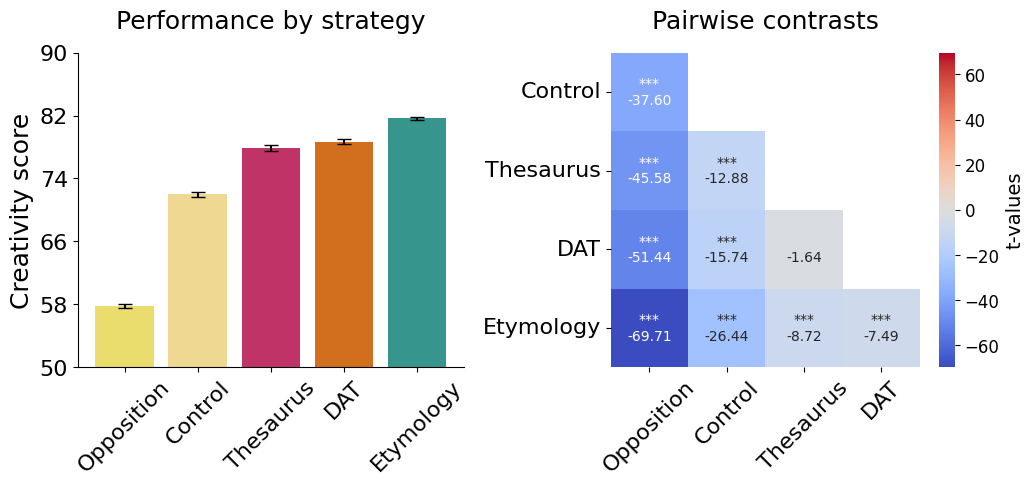

In [24]:
###PLOT STRATEGIES FOR GPT-3
gpt = "GPT-3"

df = results_df.loc[(results_df['Model'] == gpt) & (results_df['Temperature'] == 'Mid')]
df['Strategy'] = df['Strategy'].replace({'Original instructions': 'DAT'})
df = df.groupby('Strategy').apply(lambda x: x[np.abs(x['Score'] - x['Score'].mean()) <= 3 * x['Score'].std()]).reset_index(drop=True)
df = df.groupby('Strategy').apply(lambda x: x.sample(min(len(x), 500), random_state=42)).reset_index(drop=True)
df = df[df['Strategy'] != 'Random']

order = df.groupby('Strategy')['Score'].mean().sort_values(ascending=True).index
pal_order = get_palette(gpt, order)
# Initialize the FacetGrid gpt
g = sns.FacetGrid(df,row="Strategy", hue="Strategy", aspect=9,
                  height=1,row_order=order, palette=pal_order, hue_order=order)
for ax in g.axes.flat:
    ax.set_facecolor('none')
# Draw the densities in a few steps
g.map(sns.kdeplot, "Score",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
      ax = plt.gca()
      ax.text(0, .2, f"{label}", fontweight="bold", color=color,
                  ha="left", va="center", transform=ax.transAxes, fontsize=16)
g.map(label, "Score")
# Add vertical lines for mean and confidence intervals
mean_conf, pvals, tvals = analyze_results(df, 'Strategy', order=order)
for ax, model in zip(g.axes.flat, order):
      ax.axvline(mean_conf[mean_conf['Strategy'] == model]['median'].values[0], color='black', linestyle='--', ymin=0, ymax=0.5)
for ax in g.axes.flat:
    ax.set_xlabel('Creativity score', fontsize=16)
    for label in ax.get_xticklabels():
        label.set_fontsize(16)
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.32)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.set(xlim=(35, 100))
g.despine(bottom=True, left=True)
g.savefig('GPT3_strategy3_kde.png', dpi=300)

create_heatmap(mean_conf, 'Strategy', tvals_table=tvals,
            pvals_table=pvals, order=order, pal=pal_order, color_order=pal_order, large=(10.5, 5), xlim=(50, 90),
            save='GPT3_final', rotation=45, title_name='Performance by strategy', axis_name='Creativity score')


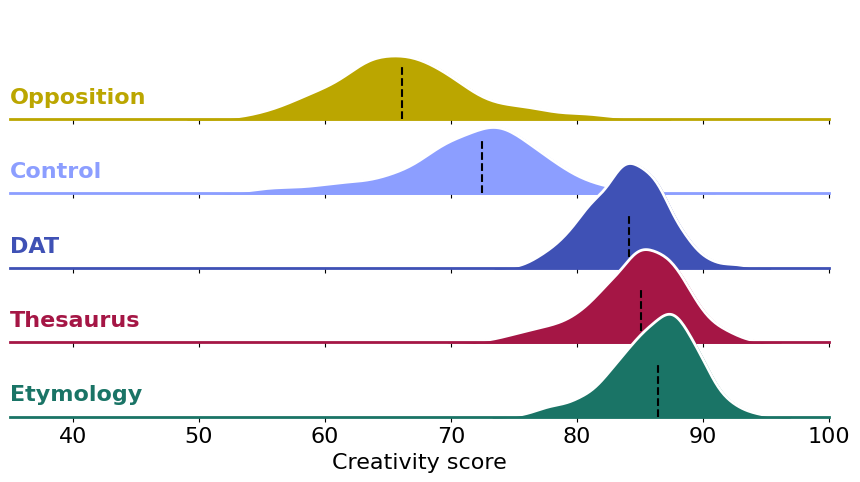

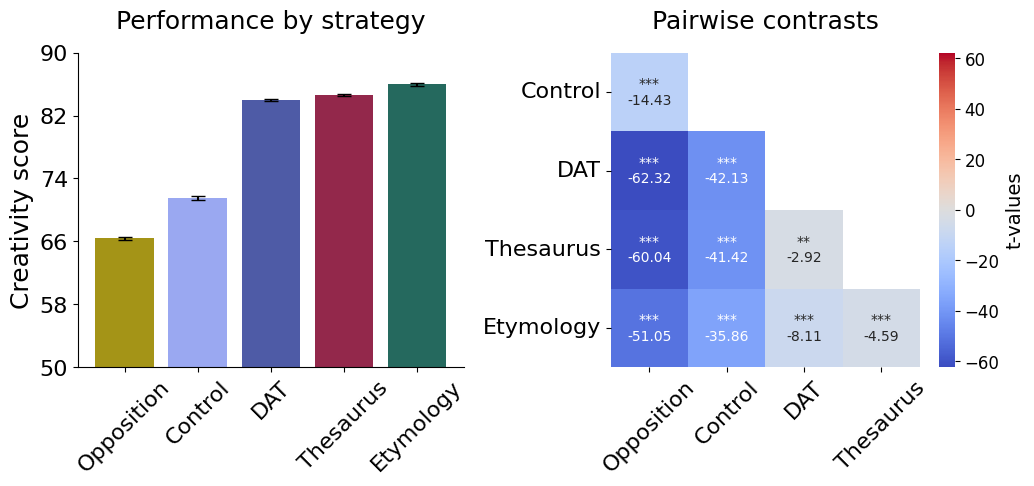

In [25]:
###PLOT STRATEGIES FOR GPT-4

gpt = "GPT-4"

df = results_df.loc[(results_df['Model'] == gpt) & (results_df['Temperature'] == 'Mid')]
df['Strategy'] = df['Strategy'].replace({'Original instructions': 'DAT', 'Control': 'Control'})
df_all = df.copy()

#df_all['Strategy'] = df_all['Strategy'].replace({'Original instructions': 'DAT', 'Control': 'Random (Control)'})
df_all = df_all.groupby('Strategy').apply(lambda x: x.sample(min(len(x), 500), random_state=42)).reset_index(drop=True)
df = df.groupby('Strategy').apply(lambda x: x[np.abs(x['Score'] - x['Score'].mean()) <= 3 * x['Score'].std()]).reset_index(drop=True)
df = df.groupby('Strategy').apply(lambda x: x.sample(min(len(x), 500), random_state=42)).reset_index(drop=True)

order = df.groupby('Strategy')['Score'].mean().sort_values(ascending=True).index
pal_order = get_palette(gpt, order)

# Initialize the FacetGrid gpt
g = sns.FacetGrid(df,row="Strategy", hue="Strategy", aspect=9,
                  height=1, palette=pal_order, row_order=order, hue_order=order)
for ax in g.axes.flat:
    ax.set_facecolor('none')
# Draw the densities in a few steps
g.map(sns.kdeplot, "Score",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# f"{label} ({len(df.loc[df['Strategy']==label])})"
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
      ax = plt.gca()
      ax.text(0, .2, f"{label}", fontweight="bold", color=color,
                  ha="left", va="center", transform=ax.transAxes, fontsize=16)
g.map(label, "Score")
# Add vertical lines for mean and confidence intervals
mean_conf, pvals, tvals = analyze_results(df_all, 'Strategy', order=order)
for ax, model in zip(g.axes.flat, order):
      ax.axvline(mean_conf[mean_conf['Strategy'] == model]['median'].values[0], color='black', linestyle='--', ymin=0, ymax=0.5)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.32)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.set(xlim=(35, 100))

for ax in g.axes.flat:
    ax.set_xlabel('Creativity score', fontsize=16)
    for label in ax.get_xticklabels():
        label.set_fontsize(16)

g.despine(bottom=True, left=True)

g.savefig('GPT4_strategy_kde_final_.png', dpi=300)
create_heatmap(mean_conf, 'Strategy', tvals_table=tvals,
            pvals_table=pvals, order=order, pal=pal_order, color_order=pal_order, large=(10.5, 5), xlim=(50, 90),
            save='GPT4_strategy_final.png', rotation=45, title_name='Performance by strategy', axis_name='Creativity score')


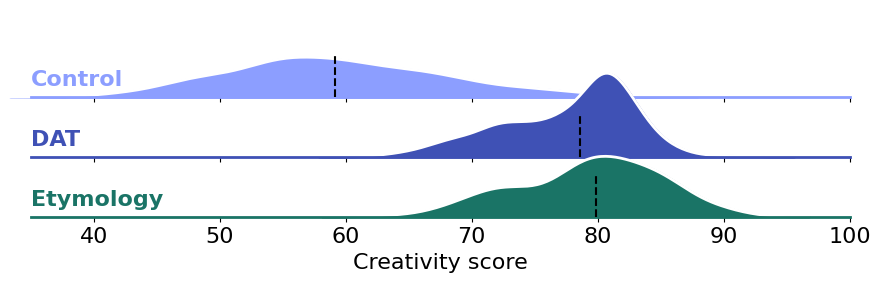

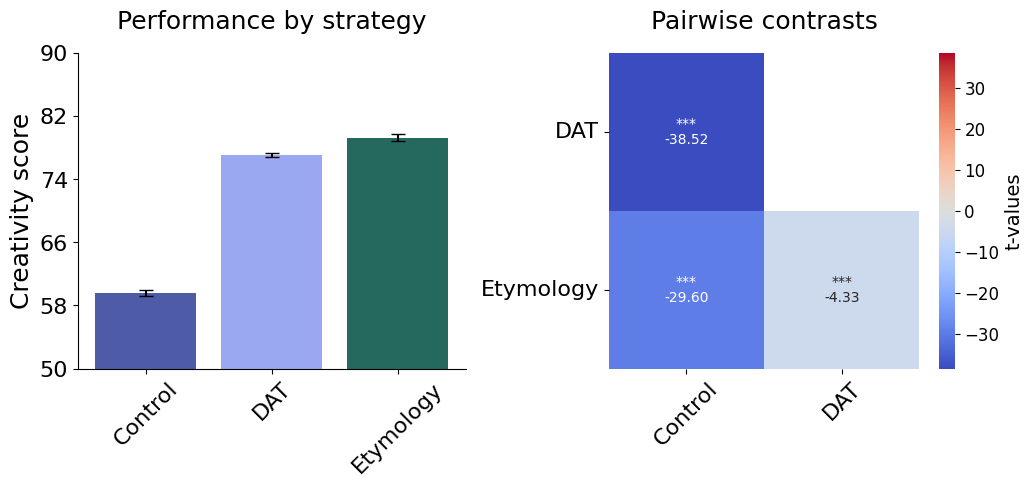

In [26]:
###PLOT STRATEGIES FOR Vicuna

df = results_df.loc[(results_df['Model'] == 'Vicuna') & (results_df['Temperature'] == 'Mid')]
df['Strategy'] = df['Strategy'].replace({'Original instructions': 'DAT', 'Control': 'Control'})
df_all = df.copy()

df_all = df_all.groupby('Strategy').apply(lambda x: x.sample(min(len(x), 500), random_state=42)).reset_index(drop=True)
df = df.groupby('Strategy').apply(lambda x: x[np.abs(x['Score'] - x['Score'].mean()) <= 3 * x['Score'].std()]).reset_index(drop=True)
df = df.groupby('Strategy').apply(lambda x: x.sample(min(len(x), 500), random_state=42)).reset_index(drop=True)

order = df.groupby('Strategy')['Score'].mean().sort_values(ascending=True).index
pal_order = get_palette(gpt, order)

# Initialize the FacetGrid gpt
g = sns.FacetGrid(df,row="Strategy", hue="Strategy", aspect=9,
                  height=1, palette=[pal_order[0], pal_order[1], pal_order[2]], row_order=order, hue_order=order)
for ax in g.axes.flat:
    ax.set_facecolor('none')
# Draw the densities in a few steps
g.map(sns.kdeplot, "Score",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# f"{label} ({len(df.loc[df['Strategy']==label])})"
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
      ax = plt.gca()
      ax.text(0, .2, f"{label}", fontweight="bold", color=color,
                  ha="left", va="center", transform=ax.transAxes, fontsize=16)
g.map(label, "Score")
# Add vertical lines for mean and confidence intervals
mean_conf, pvals, tvals = analyze_results(df_all, 'Strategy', order=order)
for ax, model in zip(g.axes.flat, order):
      ax.axvline(mean_conf[mean_conf['Strategy'] == model]['median'].values[0], color='black', linestyle='--', ymin=0, ymax=0.5)
      
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.32)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.set(xlim=(35, 100))

for ax in g.axes.flat:
    ax.set_xlabel('Creativity score', fontsize=16)
    for label in ax.get_xticklabels():
        label.set_fontsize(16)

g.despine(bottom=True, left=True)

g.savefig('GPT4_strategy_kde_final_.png', dpi=300)
create_heatmap(mean_conf, 'Strategy', tvals_table=tvals,
            pvals_table=pvals, order=order, pal=pal_order, color_order=[pal_order[1], pal_order[0], pal_order[2]], large=(10.5, 5), xlim=(50, 90),
            save='GPT4_strategy_final.png', rotation=45, title_name='Performance by strategy', axis_name='Creativity score')


## Effect of temperature 

In [27]:
def normalize_filter_std_n(group):
    group_filtered = group[np.abs(group['Score'] - group['Score'].mean()) <= 3 * group['Score'].std()]
    return group_filtered.sample(min(len(group_filtered), 500), random_state=42)

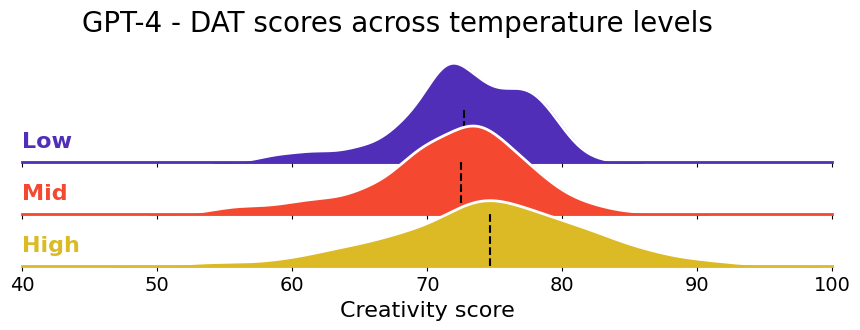

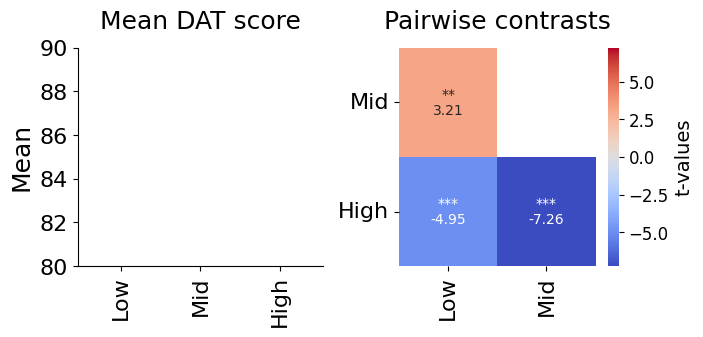

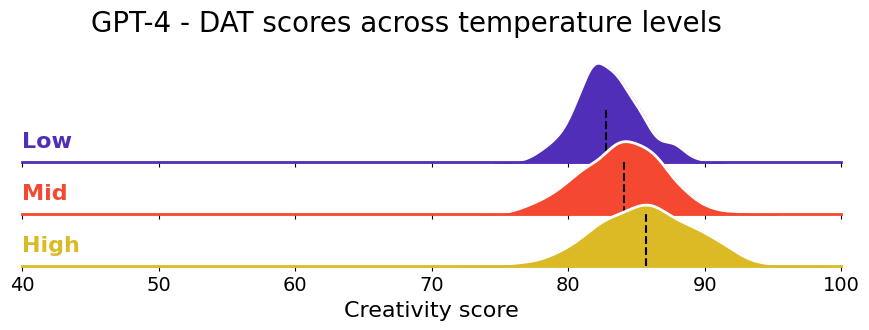

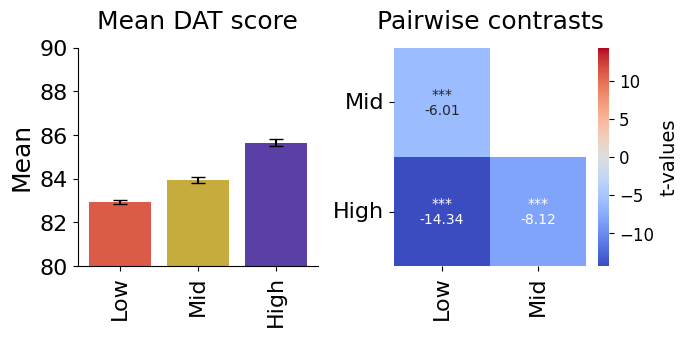

In [28]:
list_of_dfs = [results_df.loc[(results_df['Model']=='GPT-4') & 
                              (results_df['Control']=='Control')],
               results_df.loc[(results_df['Model']=='GPT-4') &
                              (results_df['Control']=='Original instructions')]]
conditions = ['Low', 'Mid', 'High']
list_of_dfs_normalized_filtered = [df.groupby('Temperature', as_index=False).apply(normalize_filter_std_n) for df in list_of_dfs]
for e, df in enumerate(list_of_dfs_normalized_filtered):
      # Initialize the FacetGrid object
      pal = sns.color_palette('CMRmap',n_colors=3, desat=.9)
      # keep color order consistent
      g = sns.FacetGrid(df, row="Temperature", hue="Temperature", aspect=9, height=1, palette=pal, row_order=conditions, hue_order=conditions)
      for ax in g.axes.flat:
            ax.set_facecolor('none')
      # increase size of condition names
      g.set_titles(fontsize=16)
      # Draw the densities in a few steps
      g.map(sns.kdeplot, "Score",
            bw_adjust=1, clip_on=False,
            fill=True, alpha=1, linewidth=1.5)
      g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)

      # passing color=None to refline() uses the hue mapping
      g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

      def label(ax, color, label):
            txt = f"{label}"
            ax.text(0, .2, txt, fontweight="bold", color=color,
                        ha="left", va="center", transform=ax.transAxes,fontsize=16)

      # Set the subplots to overlap
      for ax, model, color in zip(g.axes.flat, ['Low', 'Mid', 'High'], [pal[0], pal[1], pal[2]]):
            ax.set_xlabel('Creativity score', fontsize=16)
            label(ax, color, model)
            for label in ax.get_xticklabels():
                  label.set_fontsize(14)
       # Add vertical lines for mean and confidence intervals
      mean_conf, pvals, tvals = analyze_results(df, 'Temperature', order=conditions)
      for ax, model in zip(g.axes.flat, ['Low', 'Mid', 'High']):
            ax.axvline(mean_conf[mean_conf['Temperature'] == model]['median'].values[0], color='black', linestyle='--', ymin=0, ymax=0.5)

      # Set the subplots to overlap
      g.figure.subplots_adjust(hspace=-.5)

      # Remove axes details that don't play well with overlap
      g.set_titles("")
      g.set(yticks=[], ylabel="")
      g.despine(bottom=True, left=True)
      g.set(xlim=(40, 100))
      
      # Set a title for the figure
      g.fig.suptitle(f"GPT-4 - {df['Control'].unique()[0]}", fontsize=20, y=1.05)
      g.fig.suptitle(f"GPT-4 - DAT scores across temperature levels", fontsize=20, y=1.05)
      
      g.savefig('GPT_DAT_temperature2_kde{}.png'.format(e), dpi=300)
      create_heatmap(mean_conf, 'Temperature', tvals_table=tvals, pvals_table=pvals, pal=[pal[1], pal[2], pal[0]], order=['Low', 'Mid', 'High'],
                     save='GPT_DAT_temperature3_{}.png'.format(e), large=(7, 3.5), xlim=(80, 90))

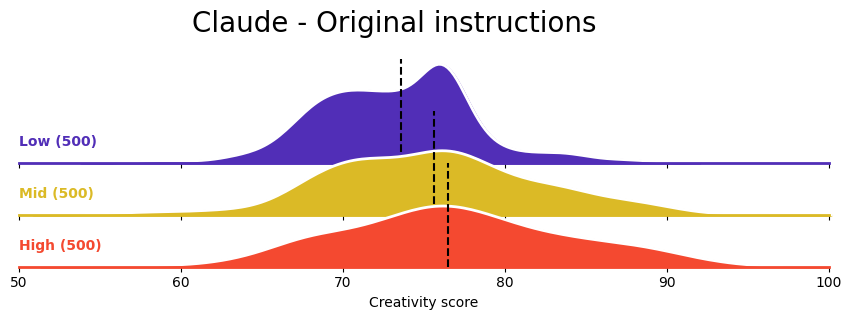

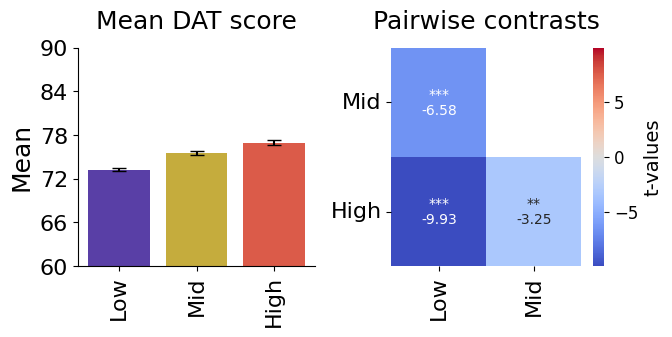

In [29]:
list_of_dfs = [results_df.loc[(results_df['Model']=='Claude') &
                              (results_df['Control']=='Original instructions')]]
conditions = ['Low', 'Mid', 'High']
list_of_dfs_normalized_filtered = [df.groupby('Temperature', as_index=False).apply(normalize_filter_std_n) for df in list_of_dfs]
for e, df in enumerate(list_of_dfs_normalized_filtered):
      # Initialize the FacetGrid object
      pal = sns.color_palette('CMRmap',n_colors=3, desat=.9)
      # keep color order consistent
      pal = [pal[1], pal[0], pal[2]]
      g = sns.FacetGrid(df, row="Temperature", hue="Temperature", aspect=9, height=1, palette=pal, row_order=conditions)
      for ax in g.axes.flat:
            ax.set_facecolor('none')
      # Draw the densities in a few steps
      g.map(sns.kdeplot, "Score",
            bw_adjust=1, clip_on=False,
            fill=True, alpha=1, linewidth=1.5)
      g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)

      # passing color=None to refline() uses the hue mapping
      g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


      # Define and use a simple function to label the plot in axes coordinates
      def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, f"{label} ({len(df.loc[df['Temperature']==label])})",
                    fontweight="bold", color=color,ha="left", va="center",
                    transform=ax.transAxes)
      g.map(label, "Score")
       # Add vertical lines for mean and confidence intervals
      mean_conf, pvals, tvals = analyze_results(df, 'Temperature', order=conditions)
      for ax, model in zip(g.axes.flat, ['Low', 'Mid', 'High']):
            ax.axvline(mean_conf[mean_conf['Temperature'] == model]['median'].values[0], color='black', linestyle='--')
      # Set the subplots to overlap
      g.figure.subplots_adjust(hspace=-.5)

      # Remove axes details that don't play well with overlap
      g.set_titles("")
      g.set(yticks=[], ylabel="", xlabel='Creativity score')
      g.despine(bottom=True, left=True)
      g.set(xlim=(50, 100))
      
      # Set a title for the figure
      g.fig.suptitle(f"Claude - {df['Control'].unique()[0]}", fontsize=20, y=1.05)
      g.savefig('CLAUDE_DAT_temperature2_kde{}.png'.format(e), dpi=300)
      create_heatmap(mean_conf, 'Temperature', tvals_table=tvals, pvals_table=pvals, pal=[pal[1], pal[2], pal[0]],
                     order=['Low', 'Mid', 'High'], save='CLAUDE_DAT_temperature3_{}.png'.format(e), large=(7, 3.5))

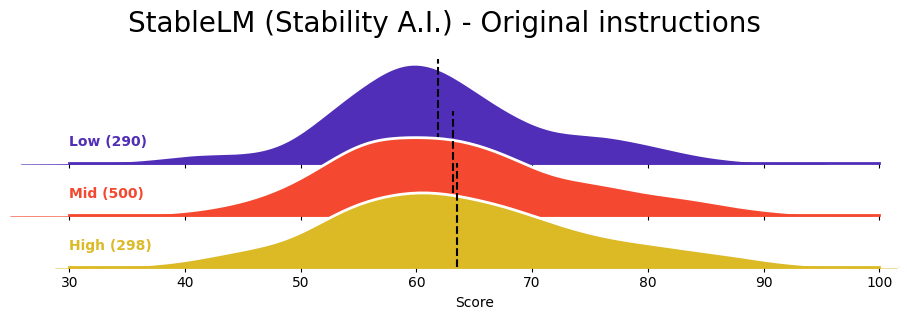

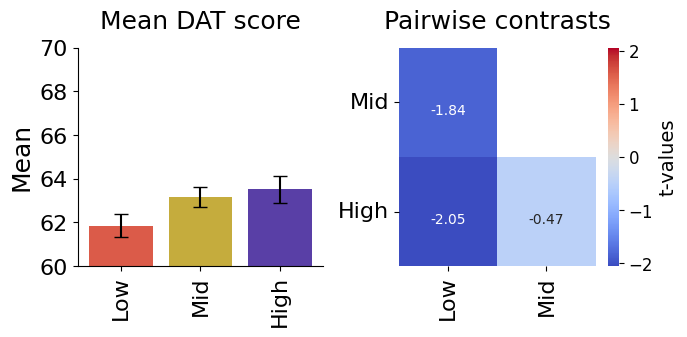

In [33]:
list_of_dfs = [results_df.loc[(results_df['Model']=='StableLM') &
                              (results_df['Control']=='Original instructions')]]
conditions = ['Low', 'Mid', 'High']
list_of_dfs_normalized_filtered = [df.groupby('Temperature', as_index=False).apply(normalize_filter_std_n) for df in list_of_dfs]
for e, df in enumerate(list_of_dfs_normalized_filtered):
      # Initialize the FacetGrid object
      pal = sns.color_palette('CMRmap',n_colors=3, desat=.9)
      # keep color order consistent
      g = sns.FacetGrid(df, row="Temperature", hue="Temperature", aspect=9, height=1, palette=pal, row_order=conditions, hue_order=conditions)
      for ax in g.axes.flat:
            ax.set_facecolor('none')
      # Draw the densities in a few steps
      g.map(sns.kdeplot, "Score",
            bw_adjust=1, clip_on=False,
            fill=True, alpha=1, linewidth=1.5)
      g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)

      # passing color=None to refline() uses the hue mapping
      g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


      # Define and use a simple function to label the plot in axes coordinates
      def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, f"{label} ({len(df.loc[df['Temperature']==label])})",
                    fontweight="bold", color=color,ha="left", va="center",
                    transform=ax.transAxes)
      g.map(label, "Score")
       # Add vertical lines for mean and confidence intervals
      mean_conf, pvals, tvals = analyze_results(df, 'Temperature', order=conditions)
      for ax, model in zip(g.axes.flat, ['Low', 'Mid', 'High']):
            ax.axvline(mean_conf[mean_conf['Temperature'] == model]['mean'].values[0], color='black', linestyle='--')
      # Set the subplots to overlap
      g.figure.subplots_adjust(hspace=-.5)

      # Remove axes details that don't play well with overlap
      g.set_titles("")
      g.set(yticks=[], ylabel="")
      g.despine(bottom=True, left=True)
      g.set(xlim=(30, 100))
      
      # Set a title for the fgure
      g.fig.suptitle(f"StableLM (Stability A.I.) - {df['Control'].unique()[0]}", fontsize=20, y=1.05)
      g.savefig('StableLM_temperature2_kde{}.png'.format(e), dpi=300)
      create_heatmap(mean_conf, 'Temperature', tvals_table=tvals, pvals_table=pvals, pal=[pal[1], pal[2], pal[0]],
                     order=['Low', 'Mid', 'High'], save='StableLM_DAT_temperature2_{}.png'.format(e), large=(7, 3.5), xlim=(60, 70))

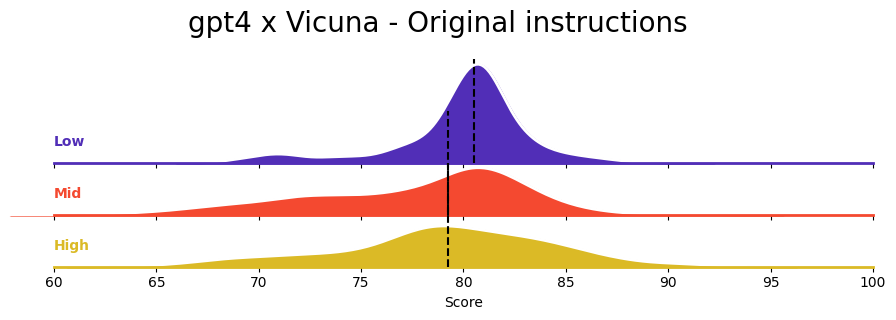

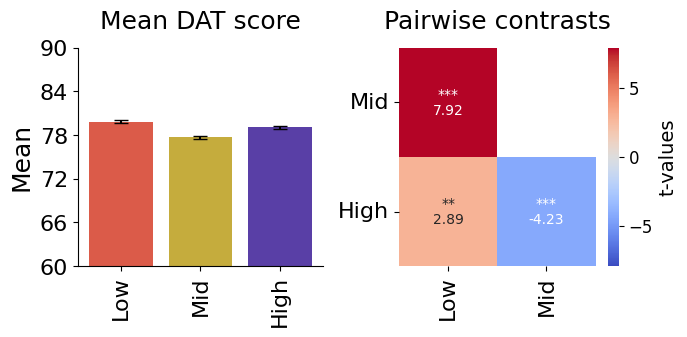

In [31]:
list_of_dfs = [results_df.loc[(results_df['Model']=='Vicuna') &
                              (results_df['Control']=='Original instructions')]]
conditions = ['Low', 'Mid', 'High']
list_of_dfs_normalized_filtered = [df.groupby('Temperature', as_index=False).apply(normalize_filter_std_n) for df in list_of_dfs]
for e, df in enumerate(list_of_dfs_normalized_filtered):
      # Initialize the FacetGrid object
      pal = list(sns.color_palette('CMRmap',n_colors=3, desat=.9))
      # keep color order consistent
      g = sns.FacetGrid(df, row="Temperature", hue="Temperature", aspect=9, height=1, palette=pal, row_order=conditions, hue_order=conditions)
      for ax in g.axes.flat:
            ax.set_facecolor('none')
      # Draw the densities in a few steps
      g.map(sns.kdeplot, "Score",
            bw_adjust=1, clip_on=False,
            fill=True, alpha=1, linewidth=1.5)
      g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)

      # passing color=None to refline() uses the hue mapping
      g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

      # f"{label} ({len(df.loc[df['Temperature']==label])})"
      # Define and use a simple function to label the plot in axes coordinates
      def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, f"{label}",
                    fontweight="bold", color=color,ha="left", va="center",
                    transform=ax.transAxes)
      g.map(label, "Score")
       # Add vertical lines for mean and confidence intervals
      mean_conf, pvals, tvals = analyze_results(df, 'Temperature', order=conditions)
      for ax, model in zip(g.axes.flat, ['Low', 'Mid', 'High']):
            ax.axvline(mean_conf[mean_conf['Temperature'] == model]['median'].values[0], color='black', linestyle='--')
      # Set the subplots to overlap
      g.figure.subplots_adjust(hspace=-.5)

      # Remove axes details that don't play well with overlap
      g.set_titles("")
      g.set(yticks=[], ylabel="")
      g.despine(bottom=True, left=True)
      g.set(xlim=(60, 100))
      
      # Set a title for the figure
      g.fig.suptitle(f"gpt4 x Vicuna - {df['Control'].unique()[0]}", fontsize=20, y=1.05)
      g.savefig('Vicuna_DAT_temperature_kde{}.png'.format(e), dpi=300)
      create_heatmap(mean_conf, 'Temperature', tvals_table=tvals, pvals_table=pvals, pal=[pal[1], pal[2], pal[0]], order=['Low', 'Mid', 'High'],
                     save='Vicuna_DAT_temperature_{}.png'.format(e), large=(7, 3.5), xlim=(60, 90))

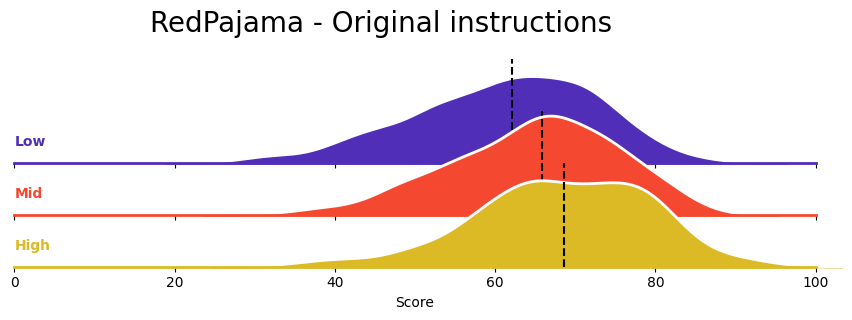

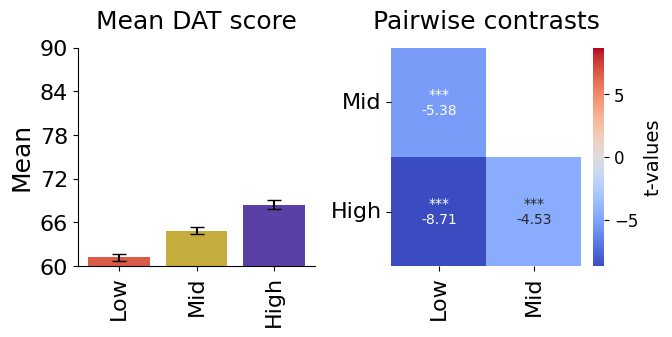

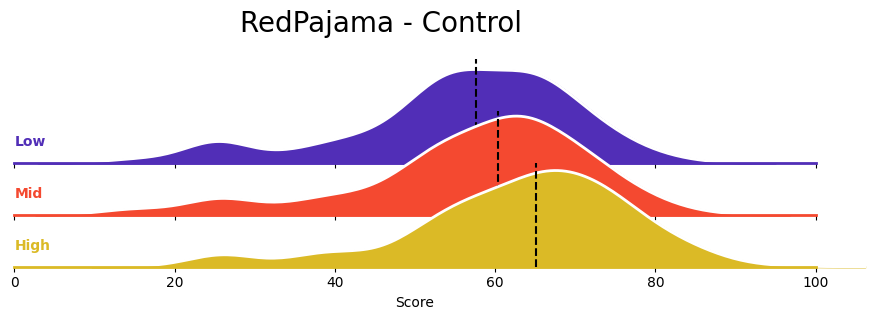

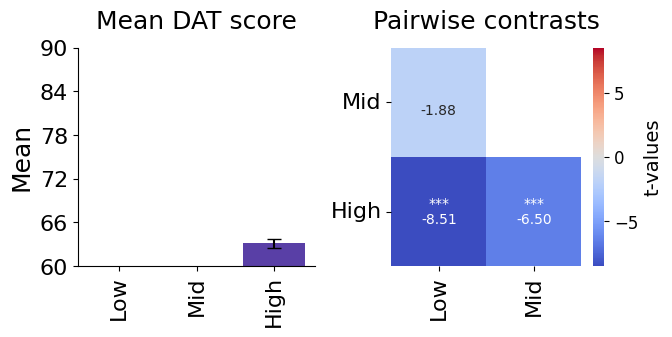

In [32]:
list_of_dfs = [results_df.loc[(results_df['Model']=='RedPajama') &
                              (results_df['Control']=='Original instructions')],
               results_df.loc[(results_df['Model']=='RedPajama') &
                              (results_df['Control']=='Control')]]
conditions = ['Low', 'Mid', 'High']
list_of_dfs_normalized_filtered = [df.groupby('Temperature', as_index=False).apply(normalize_filter_std_n) for df in list_of_dfs]
for e, df in enumerate(list_of_dfs_normalized_filtered):
      # Initialize the FacetGrid object
      pal = sns.color_palette('CMRmap',n_colors=3, desat=.9)
      # keep color order consistent
      g = sns.FacetGrid(df, row="Temperature", hue="Temperature", aspect=9, height=1, palette=pal, row_order=conditions, hue_order=conditions)
      for ax in g.axes.flat:
            ax.set_facecolor('none')
      # Draw the densities in a few steps
      g.map(sns.kdeplot, "Score",
            bw_adjust=1, clip_on=False,
            fill=True, alpha=1, linewidth=1.5)
      g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)

      # passing color=None to refline() uses the hue mapping
      g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

      # f"{label} ({len(df.loc[df['Temperature']==label])})"
      # Define and use a simple function to label the plot in axes coordinates
      def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, f"{label}",
                    fontweight="bold", color=color,ha="left", va="center",
                    transform=ax.transAxes)
      g.map(label, "Score")
       # Add vertical lines for mean and confidence intervals
      mean_conf, pvals, tvals = analyze_results(df, 'Temperature', order=conditions)
      for ax, model in zip(g.axes.flat, ['Low', 'Mid', 'High']):
            ax.axvline(mean_conf[mean_conf['Temperature'] == model]['median'].values[0], color='black', linestyle='--')
      # Set the subplots to overlap
      g.figure.subplots_adjust(hspace=-.5)

      # Remove axes details that don't play well with overlap
      g.set_titles("")
      g.set(yticks=[], ylabel="")
      g.despine(bottom=True, left=True)
      g.set(xlim=(0, 100))
      
      # Set a title for the figure
      g.fig.suptitle(f"RedPajama - {df['Control'].unique()[0]}", fontsize=20, y=1.05)
      g.savefig('RedPajama_DAT_temperature_kde{}.png'.format(e), dpi=300)
      create_heatmap(mean_conf, 'Temperature', tvals_table=tvals, pvals_table=pvals, pal=[pal[1], pal[2], pal[0]], order=['Low', 'Mid', 'High'],
                     save='RedPajama_DAT_temperature_{}.png'.format(e), large=(7, 3.5), xlim=(60, 90))